# Fine-tuning of a model for segmentation of retinal optical coherence tomography images (AROI)

For more info, check the README.md file.

## Test the fine-tuned model on some images

This notebook uses the fine-tuned model to segment some of the images: it displays the image as labeled by an expert next to the result of the fine-tuned nvidia/mit-b0 model.

## Citations

Information about the dataset can be found in the following publications:

M. Melinščak, M. Radmilović, Z. Vatavuk, and S. Lončarić, "Annotated retinal optical coherence tomography images (AROI) database for joint retinal layer and fluid segmentation," Automatika, vol. 62, no. 3, pp. 375-385, Jul. 2021. doi: 10.1080/00051144.2021.1973298

M. Melinščak, M. Radmilović, Z. Vatavuk, and S. Lončarić, "AROI: Annotated Retinal OCT Images database," in 2021 44th International Convention on Information, Communication and Electronic Technology (MIPRO), Sep. 2021, pp. 400-405.

M. Melinščak, "Attention-based U-net: Joint segmentation of layers and fluids from retinal OCT images," in 2023 46th International Convention on Information, Communication and Electronic Technology (MIPRO), Sep. 2021, pp. 391-396.

In [ ]:
%run 01_load_patient_images.ipynb

At inference, you have to make sure that both the model and the input data is stored in the correct memory. Afterwards you need to copy it to cpu memory to display the result.

A helper function which checks which device should be used for inference:

In [3]:
def get_torch_device() -> torch.device:
    if torch.cuda.is_available():
        print("cuda is available: using GPU(s)")
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        print("MPS is available: using Apple Silicon GPU")
        return torch.device("mps:0")
    print("No CUDA or MPS available: using the CPU")
    return torch.device("cpu")

print("get_torch_device() returns: " + str(get_torch_device()))

cuda is available: using GPU(s)
get_torch_device() returns: cuda


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


cuda is available: using GPU(s)
Patient 9, image 76


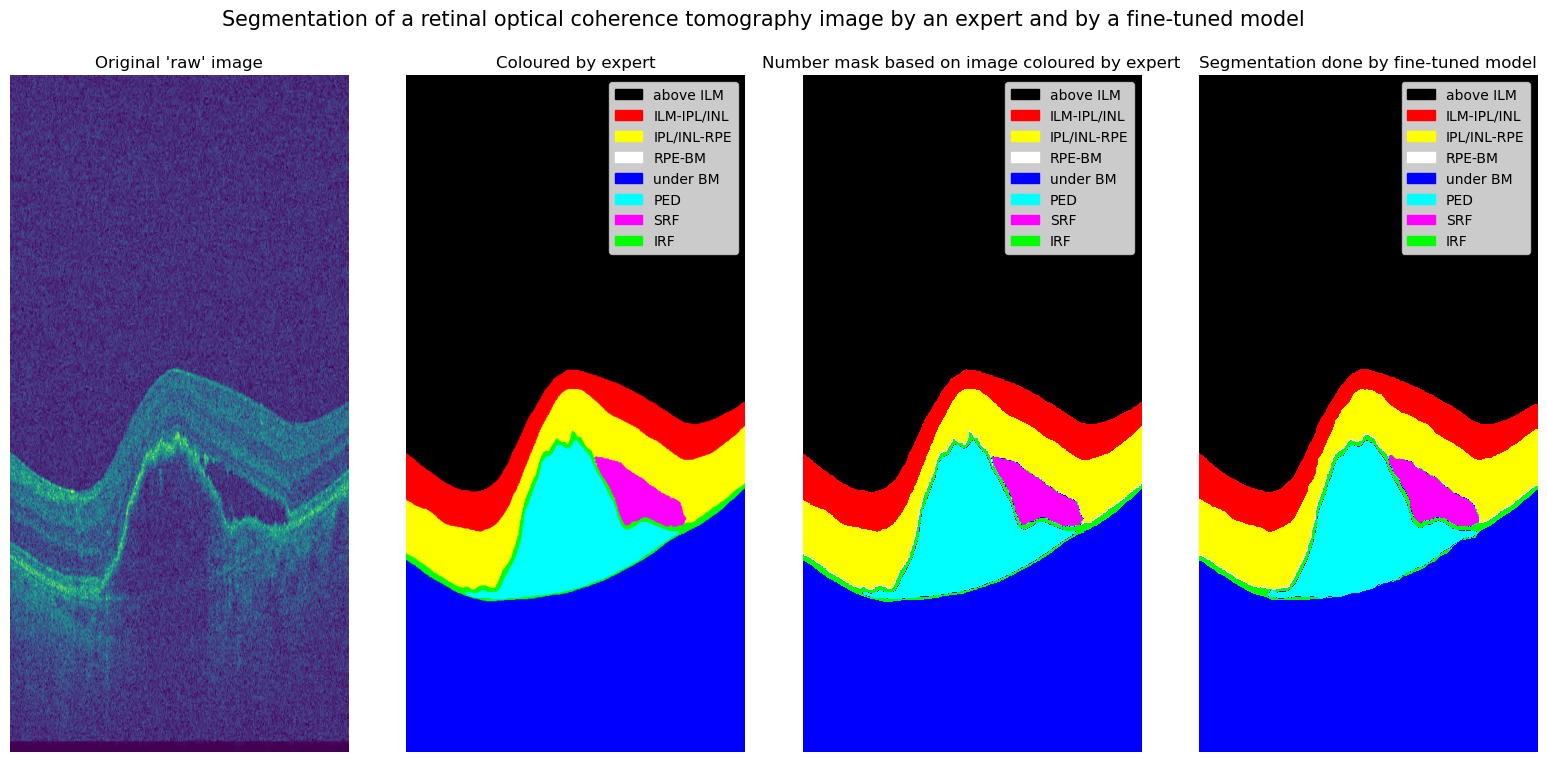

In [43]:
annotations_short: List[str] = [
    'above ILM',
    'ILM-IPL/INL',
    'IPL/INL-RPE',
    'RPE-BM',
    'under BM',
    'PED',
    'SRF',
    'IRF',
]
id2label: Dict[int,str] = {v: k for v, k in enumerate(annotations_short)}
label2id: Dict[str,int] = {v: k for k, v in id2label.items()}


def segment_with_model_and_show_result(model: AutoModelForSemanticSegmentation,
                                       feature_extractor: SegformerImageProcessor,
                                       pi: PatientImage,
                                       two_rows: bool = True,
                                       add_legends: bool = True):
    torch_device: torch.device = get_torch_device()
    print(pi)
    model = model.to(torch_device)
    image: Image = Image.open(pi.get_raw_image_as_rgb())
    with torch.no_grad():
        inputs: transformers.BatchFeature = feature_extractor(images=image, return_tensors="pt")
        inputs = inputs.to(torch_device)
    outputs: transformers.SemanticSegmenterOutput = model(**inputs)
    result: List = feature_extractor.post_process_semantic_segmentation(outputs,
                                                                        target_sizes=[(PatientImage.height,
                                                                                       PatientImage.width)])
    np_image_segmented: np.ndarray = np.array(result[0].cpu())

    fig: Figure
    ax1: Axes
    ax2: Axes
    ax3: Axes
    ax4: Axes

    if two_rows:
        fig_height = 20 
        fig_width = 10
        fig = plt.figure(figsize=(fig_width, fig_height))
        gs: GridSpec = GridSpec(2, 2)
        ax1: Axes = fig.add_subplot(gs[0, 0])
        ax2: Axes = fig.add_subplot(gs[0, 1])
        ax3: Axes = fig.add_subplot(gs[1, 0])
        ax4: Axes = fig.add_subplot(gs[1, 1])
    else:
        # single row
        fig_height = 8
        fig_width = 16
        fig = plt.figure(figsize=(fig_width, fig_height))
        gs: GridSpec = GridSpec(1, 4)
        ax1: Axes = fig.add_subplot(gs[0, 0])
        ax2: Axes = fig.add_subplot(gs[0, 1])
        ax3: Axes = fig.add_subplot(gs[0, 2])
        ax4: Axes = fig.add_subplot(gs[0, 3])

    plt.tight_layout()  
    fig.suptitle("Segmentation of a retinal optical coherence tomography image by an expert and by a fine-tuned model",
                fontsize=15)
    plt.subplots_adjust(top=0.90)
    raw: np.ndarray = np.array(Image.open(pi.raw_path))
    ax1.set_axis_off()
    ax1.imshow(raw)
    ax1.set_title("Original 'raw' image")

    number_mask_image_colours = [
        'black',
        'red',
        'yellow',
        'white',
        'lime',
        'blue',
        'aqua',
        'magenta',
    ]
    
    cmap = ListedColormap(number_mask_image_colours)

    legend_colors = list(colour_mask_image_colours.values())
    patches_short = [Patch(color=legend_colors[i], label=annotations_short[i]) for i in range(len(legend_colors))]
    patches_long = [Patch(color=legend_colors[i], label=annotations_long[i]) for i in range(len(legend_colors))]
    
    colour_mask: np.ndarray = np.array(Image.open(pi.colour_mask_path))
    ax2.set_axis_off()
    ax2.imshow(colour_mask)
    ax2.set_title("Coloured by expert")
    if add_legends:
        ax2.legend(handles=patches_short, loc='upper right')
    number_mask: np.ndarray = np.array(Image.open(pi.number_mask_path))
    ax3.set_axis_off()
    ax3.imshow(number_mask, cmap=cmap)
    ax3.set_title("Number mask based on image coloured by expert")
    if add_legends:
        ax3.legend(handles=patches_short, loc='upper right')
    ax4.set_axis_off()
    ax4.imshow(np_image_segmented, cmap=cmap)
    ax4.set_title("Segmentation done by fine-tuned model")
    if add_legends:
        ax4.legend(handles=patches_short, loc='upper right')




nvidia_mit_b0_finetuned_local_directory_name: str = "nvidia-mit-b0-finetuned"
nvidia_mit_b0_finetuned_feature_extractor: SegformerImageProcessor = \
    AutoImageProcessor.from_pretrained('nvidia/mit-b0', reduce_labels=False)
nvidia_mit_b0_finetuned_model = AutoModelForSemanticSegmentation.from_pretrained(
    nvidia_mit_b0_finetuned_local_directory_name, id2label=id2label, label2id=label2id
)

segment_with_model_and_show_result(nvidia_mit_b0_finetuned_model,
                                   nvidia_mit_b0_finetuned_feature_extractor,
                                   patient_images[30],
                                   two_rows=False)

Some more test images:

cuda is available: using GPU(s)
Patient 9, image 46


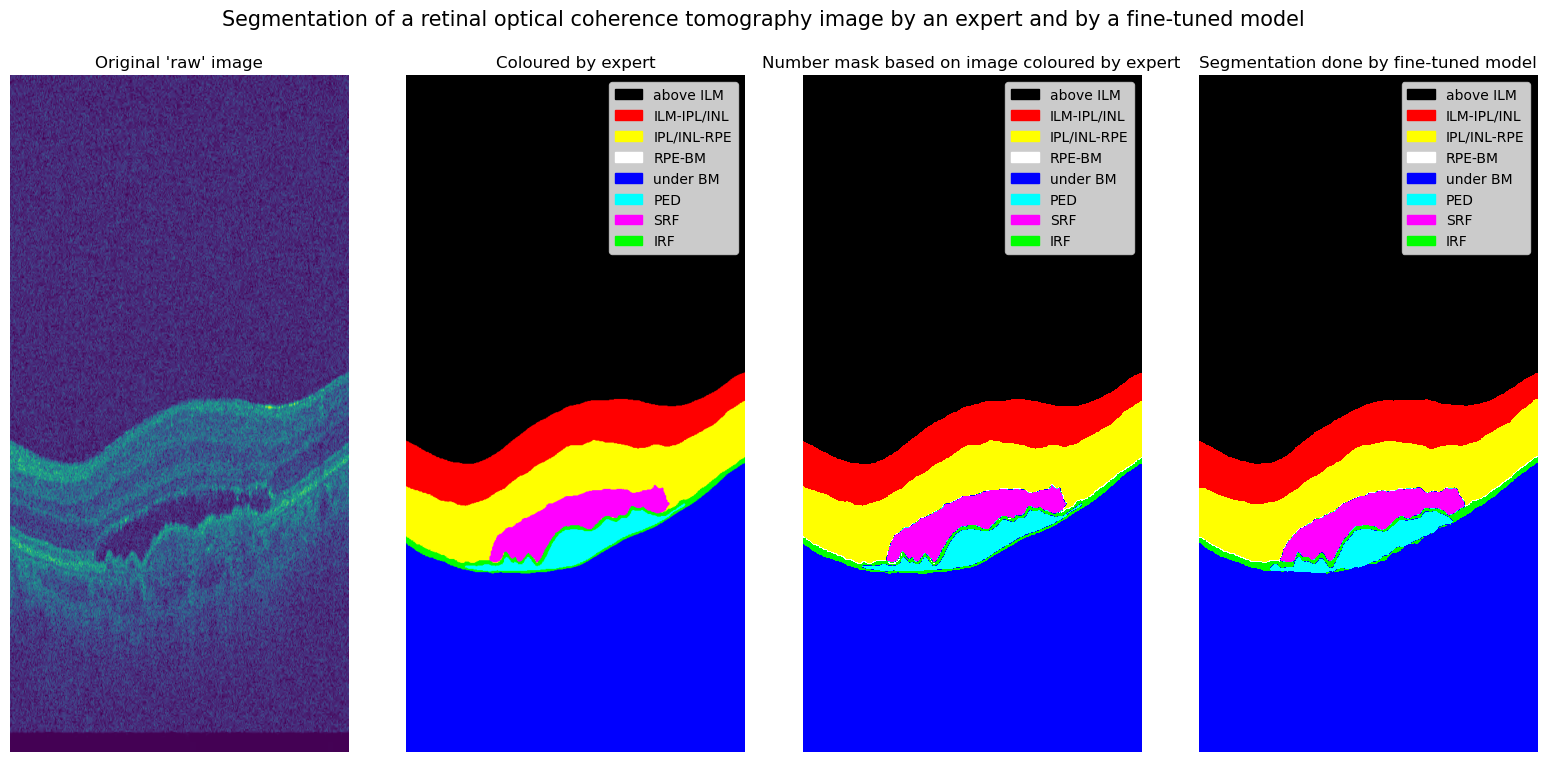

In [44]:
segment_with_model_and_show_result(nvidia_mit_b0_finetuned_model,
                                   nvidia_mit_b0_finetuned_feature_extractor,
                                   patient_images[60],
                                   two_rows=False)

cuda is available: using GPU(s)
Patient 22, image 47


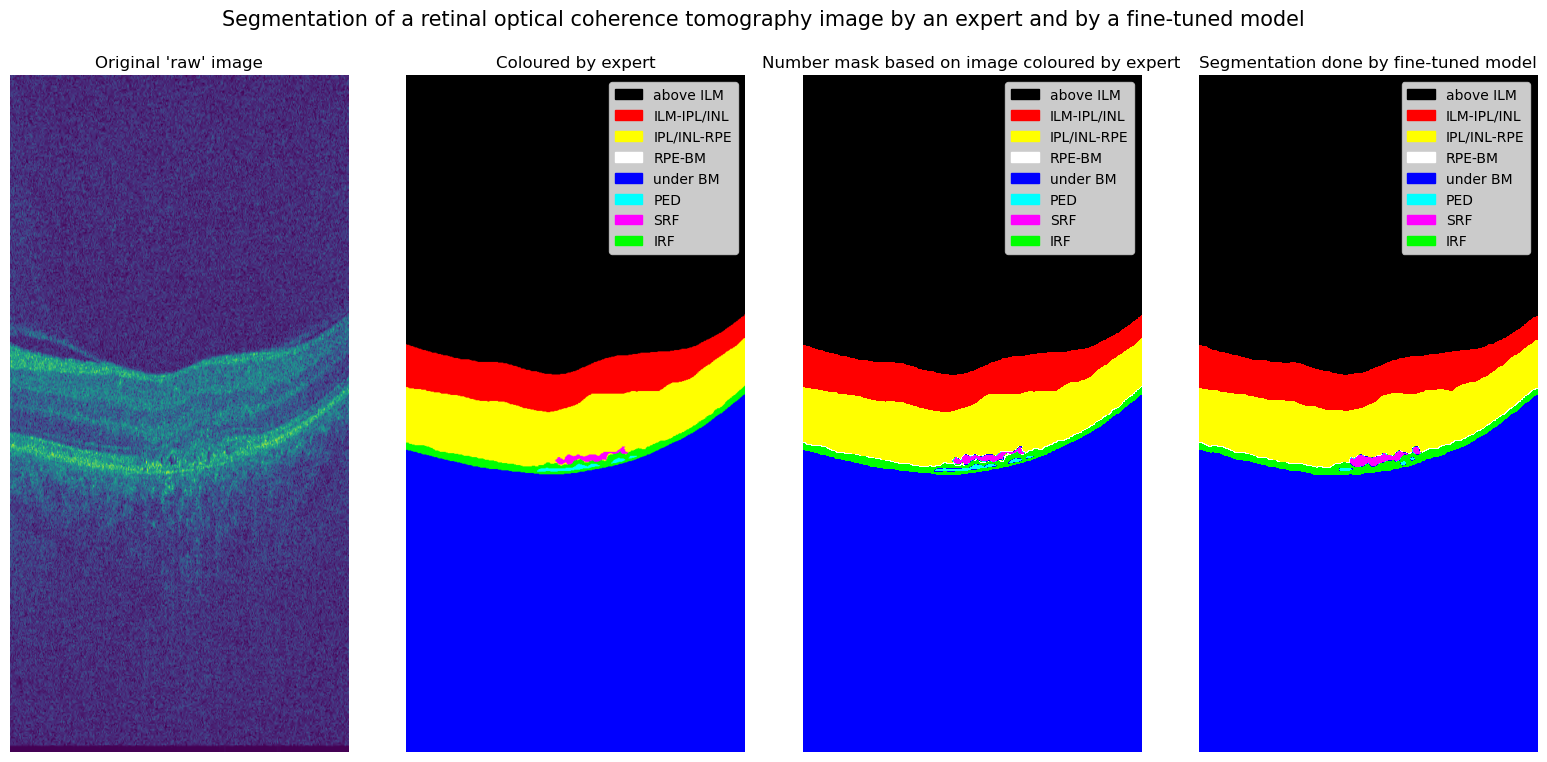

In [45]:
segment_with_model_and_show_result(nvidia_mit_b0_finetuned_model,
                                   nvidia_mit_b0_finetuned_feature_extractor,
                                   patient_images[500],
                                   two_rows=False)

I don't know for sure yet but for some images, it seems there's a mismatch between the labeled image with colours and the number mask image:

cuda is available: using GPU(s)
Patient 11, image 69


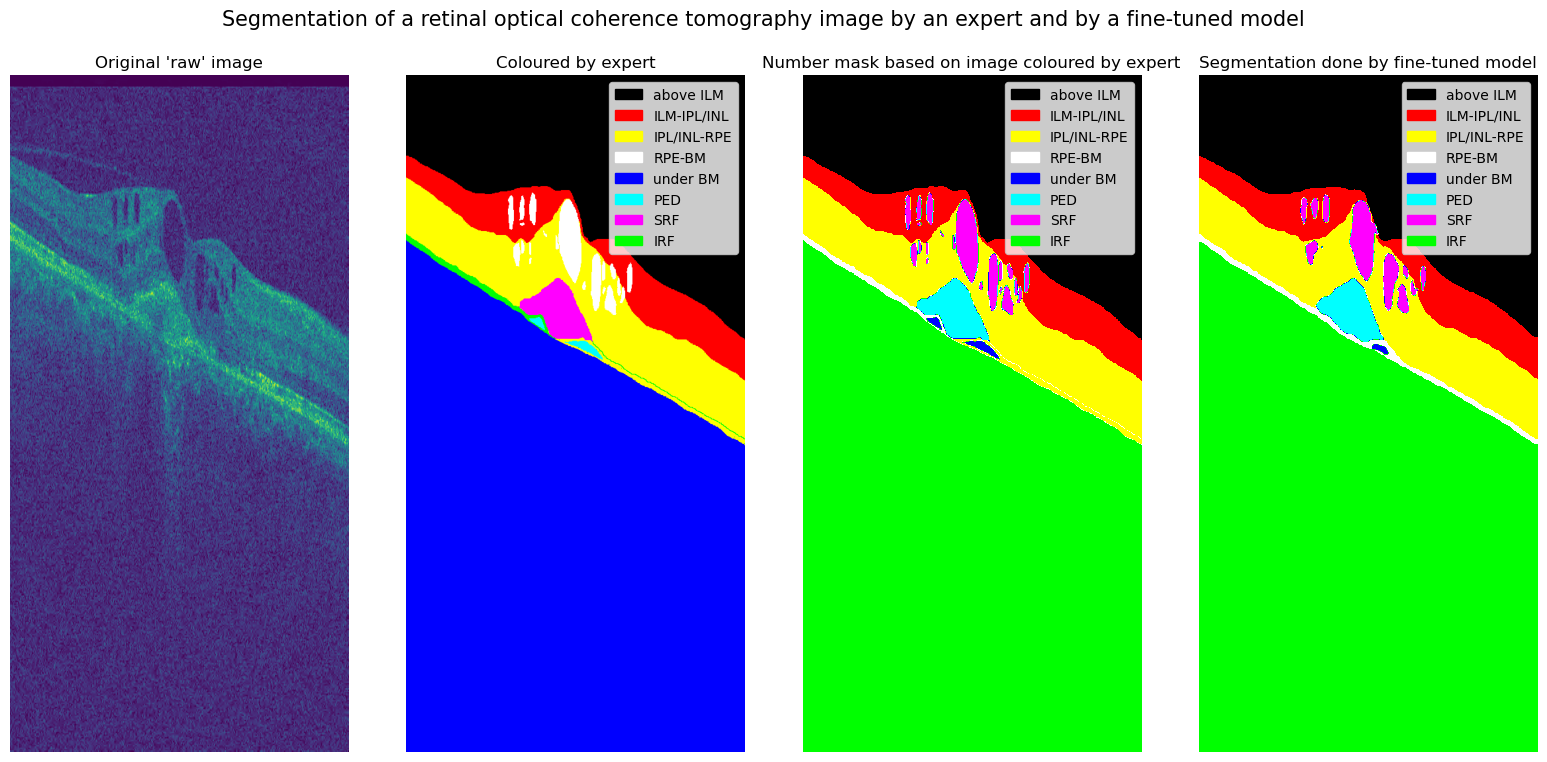

In [46]:
segment_with_model_and_show_result(nvidia_mit_b0_finetuned_model,
                                   nvidia_mit_b0_finetuned_feature_extractor,
                                   patient_images[1000],
                                   two_rows=False)